# Experiment XMI Labels Clean
> Can we get better by training on our assumptions?

In [ ]:
# default_exp experiment_xmi_labels_clean

In [ ]:
# hide
import blackhc.project.script

Appended /home/blackhc/PycharmProjects/bald-ical/src to paths
Switched to directory /home/blackhc/PycharmProjects/bald-ical
%load_ext autoreload
%autoreload 2


Import modules and functions were are going to use.

In [ ]:
# exports

import dataclasses
import traceback
from dataclasses import dataclass
from typing import Type, Union

import torch
import torch.utils.data
from blackhc.project import is_run_from_ipython
from blackhc.project.experiment import embedded_experiments
from torch.utils.data import Dataset

import batchbald_redux.acquisition_functions as acquisition_functions
from batchbald_redux.acquisition_functions import (
    CandidateBatchComputer,
    EvalCandidateBatchComputer,
)
from batchbald_redux.active_learning import ActiveLearningData, RandomFixedLengthSampler
from batchbald_redux.black_box_model_training import evaluate, train
from batchbald_redux.dataset_challenges import (
    NamedDataset,
    create_repeated_MNIST_dataset,
    get_balanced_sample_indices,
    get_base_dataset_index,
    get_target, AdditiveGaussianNoise,
)
from batchbald_redux.di import DependencyInjection
from batchbald_redux.fast_mnist import FastMNIST
from batchbald_redux.model_optimizer_factory import ModelOptimizerFactory
from batchbald_redux.models import MnistOptimizerFactory

In [ ]:
# exports

# From the BatchBALD Repo
from batchbald_redux.train_eval_model import (
    TrainEvalModel,
    TrainSelfDistillationEvalModel,
)
from batchbald_redux.trained_model import TrainedMCDropoutModel

In [ ]:
# exports

from blackhc.progress_bar import create_progress_bar
from toma import toma


def compute_entropy_from_probs(probs_N_K_C: torch.Tensor) -> torch.Tensor:
    N, K, C = probs_N_K_C.shape

    entropies_N = torch.empty(N, dtype=torch.double)

    pbar = create_progress_bar(N, tqdm_args=dict(desc="Entropy", leave=False))
    pbar.start()

    @toma.execute.chunked(probs_N_K_C, 1024)
    def compute(probs_n_K_C, start: int, end: int):
        mean_probs_n_C = probs_n_K_C.mean(dim=1)
        nats_n_C = mean_probs_n_C * torch.log(mean_probs_n_C)
        nats_n_C[mean_probs_n_C == 0] = 0.0

        entropies_N[start:end].copy_(-torch.sum(nats_n_C, dim=1))
        pbar.update(end - start)

    pbar.finish()

    return entropies_N

In [ ]:
train_predictions = torch.load("./data/mnist_train_predictions.pt", map_location="cpu")
train_entropies = compute_entropy_from_probs(train_predictions[:, None, :])

Entropy:   0%|          | 0/60000 [00:00<?, ?it/s]

In [ ]:
from matplotlib import pyplot as plt

(array([55951.,  1227.,   635.,   386.,   241.,   206.,   130.,   117.,
          118.,    74.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ]),
 <BarContainer object of 10 artists>)

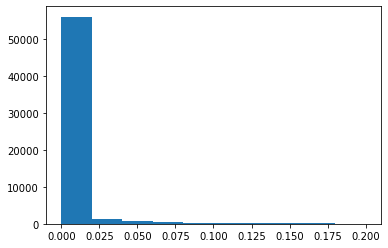

In [ ]:
plt.hist(train_entropies.cpu().numpy(), range=[0, 0.2])

In [ ]:
# exports


@dataclass
class Experiment:
    seed: int = 1337
    acquisition_size: int = 5
    max_training_set: int = 300
    num_pool_samples: int = 20
    num_validation_samples: int = 20
    num_training_samples: int = 1
    num_patience_epochs: int = 5 * 4
    max_training_epochs: int = 30 * 4
    training_batch_size: int = 64
    device: str = "cuda"
    validation_set_size: int = 1024
    initial_training_set_size: int = 20
    min_samples_per_epoch: int = 1024
    repeated_mnist_repetitions: int = 1
    add_dataset_noise: bool = False
    acquisition_function: Union[
        Type[CandidateBatchComputer], Type[EvalCandidateBatchComputer]
    ] = acquisition_functions.BALD
    train_eval_model: TrainEvalModel = TrainSelfDistillationEvalModel
    model_optimizer_factory: Type[ModelOptimizerFactory] = MnistOptimizerFactory
    acquisition_function_args: dict = None
    temperature: float = 0.0

    def load_dataset(self) -> (ActiveLearningData, Dataset, Dataset):
        train_dataset = NamedDataset(
            FastMNIST("data", train=True, download=True, device=self.device), "FastMNIST (train)"
        )
        train_predictions = torch.load("./data/mnist_train_predictions.pt", map_location=self.device)

        train_dataset = train_dataset.override_targets(targets=train_predictions.argmax(dim=1))

        train_entropies = compute_entropy_from_probs(train_predictions[:, None, :])

        allowed_indices = torch.nonzero(train_entropies < 0.01, as_tuple=True)[0].numpy()
        print(f"Removing {len(train_dataset) - len(allowed_indices)} training samples with entropy >= 0.01.")

        train_dataset = train_dataset.subset(allowed_indices)

        # If we over-sample the train set, we do so after picking the initial train set to avoid duplicates.
        if self.repeated_mnist_repetitions < 1:
            train_dataset = train_dataset * self.repeated_mnist_repetitions

        num_classes = train_dataset.get_num_classes()
        initial_samples_per_class = self.initial_training_set_size // num_classes
        initial_training_set_indices = get_balanced_sample_indices(
            train_dataset,
            num_classes=num_classes,
            samples_per_class=initial_samples_per_class,
            seed=0,
        )

        # If we over-sample the train set, we do so after picking the initial train set to avoid duplicates.
        if self.repeated_mnist_repetitions > 1:
            train_dataset = train_dataset * self.mnist_repetitions

        if self.add_dataset_noise:
            train_dataset = AdditiveGaussianNoise(train_dataset, 0.1)

        active_learning_data = ActiveLearningData(train_dataset)

        active_learning_data.acquire(initial_training_set_indices)

        validation_dataset = active_learning_data.extract_dataset_from_pool(self.validation_set_size)
        validation_dataset = NamedDataset(
            validation_dataset, f"FastMNIST (validation, {len(validation_dataset)} samples)"
        )

        test_dataset = FastMNIST("data", train=False, device=None)
        test_dataset = NamedDataset(test_dataset, f"FastMNIST (test, {len(test_dataset)} samples)")

        return active_learning_data, validation_dataset, test_dataset, initial_training_set_indices

    # Simple Dependency Injection
    def create_acquisition_function(self):
        di = DependencyInjection(vars(self))
        return di.create_dataclass_type(self.acquisition_function)

    def create_train_eval_model(self, runtime_config) -> TrainEvalModel:
        config = {**vars(self), **runtime_config}
        di = DependencyInjection(config, [])
        return di.create_dataclass_type(self.train_eval_model)

    def run(self, store):
        torch.manual_seed(self.seed)

        # Active Learning setup
        active_learning_data, validation_dataset, test_dataset, initial_training_set_indices = self.load_dataset()
        store["initial_training_set_indices"] = initial_training_set_indices
        store["dataset_info"] = dict(training=repr(active_learning_data.base_dataset), test=repr(test_dataset))

        # initial_training_set_indices = active_learning_data.get_random_pool_indices(self.initial_set_size)
        # initial_training_set_indices = get_balanced_sample_indices(
        #     active_learning_data.pool_dataset, 10, self.initial_set_size // 10
        # )

        train_loader = torch.utils.data.DataLoader(
            active_learning_data.training_dataset,
            batch_size=64,
            sampler=RandomFixedLengthSampler(active_learning_data.training_dataset, self.min_samples_per_epoch),
            drop_last=True,
        )
        pool_loader = torch.utils.data.DataLoader(
            active_learning_data.pool_dataset, batch_size=128, drop_last=False, shuffle=False
        )

        validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=128, drop_last=False)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, drop_last=False)

        store["active_learning_steps"] = []
        active_learning_steps = store["active_learning_steps"]

        acquisition_function = self.create_acquisition_function()

        # Active Training Loop
        while True:
            training_set_size = len(active_learning_data.training_dataset)
            print(f"Training set size {training_set_size}:")

            # iteration_log = dict(training={}, pool_training={}, evaluation_metrics=None, acquisition=None)
            active_learning_steps.append({})
            iteration_log = active_learning_steps[-1]

            iteration_log["training"] = {}

            model_optimizer = self.model_optimizer_factory().create_model_optimizer()

            if training_set_size > 0:
                train(
                    model=model_optimizer.model,
                    optimizer=model_optimizer.optimizer,
                    training_samples=self.num_training_samples,
                    validation_samples=self.num_validation_samples,
                    train_loader=train_loader,
                    validation_loader=validation_loader,
                    patience=self.num_patience_epochs,
                    max_epochs=self.max_training_epochs,
                    device=self.device,
                    training_log=iteration_log["training"],
                )

            evaluation_metrics = evaluate(
                model=model_optimizer.model,
                num_samples=self.num_validation_samples,
                loader=test_loader,
                device=self.device,
            )
            iteration_log["evaluation_metrics"] = evaluation_metrics
            print(f"Perf after training {evaluation_metrics}")

            if training_set_size >= self.max_training_set:
                print("Done.")
                break

            trained_model = TrainedMCDropoutModel(num_samples=self.num_pool_samples, model=model_optimizer.model)

            if isinstance(acquisition_function, CandidateBatchComputer):
                candidate_batch = acquisition_function.compute_candidate_batch(trained_model, pool_loader, self.device)
            elif isinstance(acquisition_function, EvalCandidateBatchComputer):
                current_max_epochs = iteration_log["training"]["best_epoch"]

                train_eval_model = self.create_train_eval_model(
                    dict(
                        max_epochs=current_max_epochs,
                        training_dataset=active_learning_data.training_dataset,
                        eval_dataset=active_learning_data.pool_dataset,
                        validation_loader=validation_loader,
                        trained_model=trained_model,
                    )
                )

                iteration_log["eval_training"] = {}
                trained_eval_model = train_eval_model(training_log=iteration_log["eval_training"], device=self.device)

                candidate_batch = acquisition_function.compute_candidate_batch(
                    trained_model, trained_eval_model, pool_loader, device=self.device
                )
            else:
                raise ValueError(f"Unknown acquisition function {acquisition_function}!")

            candidate_global_indices = [
                get_base_dataset_index(active_learning_data.pool_dataset, index).index
                for index in candidate_batch.indices
            ]
            candidate_labels = [
                get_target(active_learning_data.pool_dataset, index).item() for index in candidate_batch.indices
            ]

            iteration_log["acquisition"] = dict(
                indices=candidate_global_indices, labels=candidate_labels, scores=candidate_batch.scores
            )

            active_learning_data.acquire(candidate_batch.indices)

            ls = ", ".join(f"{label} ({score:.4})" for label, score in zip(candidate_labels, candidate_batch.scores))
            print(f"Acquiring (label, score)s: {ls}")

In [ ]:
# experiment

experiment = Experiment(
    seed=1120,
    max_training_epochs=50,
    num_patience_epochs=20,
    max_training_set=130,
    acquisition_function=acquisition_functions.CoreSetBALD,
    acquisition_size=1,
    num_pool_samples=20,
    initial_training_set_size=20,
    temperature=8,
    min_samples_per_epoch=1000,
    device="cuda",
)

results = {}
experiment.run(results)

Entropy:   0%|          | 0/60000 [00:00<?, ?it/s]

Removing 5678 training samples with entropy >= 0.01.
Resolved: CoreSetBALD with {'acquisition_size': 1}
Creating: CoreSetBALD(acquisition_size=1)
Training set size 20:


  2%|2         | 1/50 [00:00<?, ?it/s]

[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5234375, 'crossentropy': 1.889178678393364}


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5751953125, 'crossentropy': 1.9222656190395355}


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5751953125, 'crossentropy': 2.30680088698864}
RestoringEarlyStopping: 1 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.609375, 'crossentropy': 2.41616752743721}


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5966796875, 'crossentropy': 2.592011511325836}
RestoringEarlyStopping: 1 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6181640625, 'crossentropy': 2.569279193878174}


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6083984375, 'crossentropy': 2.8675908744335175}
RestoringEarlyStopping: 1 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.58203125, 'crossentropy': 3.0448006987571716}
RestoringEarlyStopping: 2 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.61328125, 'crossentropy': 2.8751733154058456}
RestoringEarlyStopping: 3 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.599609375, 'crossentropy': 2.9559254944324493}
RestoringEarlyStopping: 4 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.603515625, 'crossentropy': 3.007580280303955}
RestoringEarlyStopping: 5 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.623046875, 'crossentropy': 2.8509517908096313}


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.61328125, 'crossentropy': 3.0512215197086334}
RestoringEarlyStopping: 1 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.59765625, 'crossentropy': 3.490338057279587}
RestoringEarlyStopping: 2 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5986328125, 'crossentropy': 3.44213929772377}
RestoringEarlyStopping: 3 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.59765625, 'crossentropy': 3.4993003606796265}
RestoringEarlyStopping: 4 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5888671875, 'crossentropy': 3.356961280107498}
RestoringEarlyStopping: 5 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5966796875, 'crossentropy': 3.4599979519844055}
RestoringEarlyStopping: 6 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5859375, 'crossentropy': 3.476104587316513}
RestoringEarlyStopping: 7 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.591796875, 'crossentropy': 3.5656451284885406}
RestoringEarlyStopping: 8 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6142578125, 'crossentropy': 3.4628580808639526}
RestoringEarlyStopping: 9 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6181640625, 'crossentropy': 3.2809011042118073}
RestoringEarlyStopping: 10 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6181640625, 'crossentropy': 3.354946047067642}
RestoringEarlyStopping: 11 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6064453125, 'crossentropy': 3.4149722158908844}
RestoringEarlyStopping: 12 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5927734375, 'crossentropy': 3.476822406053543}
RestoringEarlyStopping: 13 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6220703125, 'crossentropy': 3.2857909500598907}
RestoringEarlyStopping: 14 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.62109375, 'crossentropy': 3.401293307542801}
RestoringEarlyStopping: 15 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6064453125, 'crossentropy': 3.717960834503174}
RestoringEarlyStopping: 16 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5810546875, 'crossentropy': 3.936969965696335}
RestoringEarlyStopping: 17 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.609375, 'crossentropy': 3.5731894969940186}
RestoringEarlyStopping: 18 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.59375, 'crossentropy': 3.838055431842804}
RestoringEarlyStopping: 19 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5947265625, 'crossentropy': 3.8724742233753204}
RestoringEarlyStopping: 20 / 20
RestoringEarlyStopping: Out of patience
RestoringEarlyStopping: Restoring best parameters. (Score: 0.623046875)
RestoringEarlyStopping: Restoring optimizer.


[1/79]   1%|1          [00:00<?]

Perf after training {'accuracy': 0.6196, 'crossentropy': 2.938227836227417}


get_predictions_labels:   0%|          | 0/1065560 [00:00<?, ?it/s]

Acquiring (label, score)s: 3 (2.984)
Training set size 21:


  2%|2         | 1/50 [00:00<?, ?it/s]

[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.412109375, 'crossentropy': 2.0124351531267166}


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5517578125, 'crossentropy': 1.9419382512569427}


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.580078125, 'crossentropy': 2.3304973393678665}


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5615234375, 'crossentropy': 2.8050885796546936}
RestoringEarlyStopping: 1 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.61328125, 'crossentropy': 2.7151154279708862}


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.595703125, 'crossentropy': 2.7696069180965424}
RestoringEarlyStopping: 1 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5810546875, 'crossentropy': 3.0981011986732483}
RestoringEarlyStopping: 2 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.576171875, 'crossentropy': 3.13588684797287}
RestoringEarlyStopping: 3 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.572265625, 'crossentropy': 3.1821422576904297}
RestoringEarlyStopping: 4 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5986328125, 'crossentropy': 3.3317853808403015}
RestoringEarlyStopping: 5 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5888671875, 'crossentropy': 3.4484546780586243}
RestoringEarlyStopping: 6 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.580078125, 'crossentropy': 3.3273661732673645}
RestoringEarlyStopping: 7 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5986328125, 'crossentropy': 3.242195874452591}
RestoringEarlyStopping: 8 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5830078125, 'crossentropy': 3.461581528186798}
RestoringEarlyStopping: 9 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.603515625, 'crossentropy': 3.097506195306778}
RestoringEarlyStopping: 10 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.607421875, 'crossentropy': 3.0208186209201813}
RestoringEarlyStopping: 11 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5966796875, 'crossentropy': 3.258731335401535}
RestoringEarlyStopping: 12 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.560546875, 'crossentropy': 3.702712833881378}
RestoringEarlyStopping: 13 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5859375, 'crossentropy': 3.4598130583763123}
RestoringEarlyStopping: 14 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.583984375, 'crossentropy': 3.766517221927643}
RestoringEarlyStopping: 15 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5615234375, 'crossentropy': 3.8230625987052917}
RestoringEarlyStopping: 16 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.583984375, 'crossentropy': 3.624999612569809}
RestoringEarlyStopping: 17 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5810546875, 'crossentropy': 3.6893355548381805}
RestoringEarlyStopping: 18 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.580078125, 'crossentropy': 3.82569482922554}
RestoringEarlyStopping: 19 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5986328125, 'crossentropy': 3.5616321861743927}
RestoringEarlyStopping: 20 / 20
RestoringEarlyStopping: Out of patience
RestoringEarlyStopping: Restoring best parameters. (Score: 0.61328125)
RestoringEarlyStopping: Restoring optimizer.


[1/79]   1%|1          [00:00<?]

Perf after training {'accuracy': 0.5891, 'crossentropy': 2.848759317779541}


get_predictions_labels:   0%|          | 0/1065540 [00:00<?, ?it/s]

Acquiring (label, score)s: 7 (2.941)
Training set size 22:


  2%|2         | 1/50 [00:00<?, ?it/s]

[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.4833984375, 'crossentropy': 2.0725049674510956}


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5810546875, 'crossentropy': 1.8447204530239105}


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.61328125, 'crossentropy': 2.3418411165475845}


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6103515625, 'crossentropy': 2.5211633443832397}
RestoringEarlyStopping: 1 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.63671875, 'crossentropy': 2.61277112364769}


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.63671875, 'crossentropy': 2.7985386550426483}
RestoringEarlyStopping: 1 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6171875, 'crossentropy': 2.9907675683498383}
RestoringEarlyStopping: 2 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6171875, 'crossentropy': 2.8883813321590424}
RestoringEarlyStopping: 3 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6162109375, 'crossentropy': 3.1081900000572205}
RestoringEarlyStopping: 4 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6171875, 'crossentropy': 2.8662006556987762}
RestoringEarlyStopping: 5 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.626953125, 'crossentropy': 2.971672624349594}
RestoringEarlyStopping: 6 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6337890625, 'crossentropy': 2.9306421875953674}
RestoringEarlyStopping: 7 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.630859375, 'crossentropy': 3.091505616903305}
RestoringEarlyStopping: 8 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6328125, 'crossentropy': 2.960479199886322}
RestoringEarlyStopping: 9 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6201171875, 'crossentropy': 3.3163605332374573}
RestoringEarlyStopping: 10 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6181640625, 'crossentropy': 3.388724535703659}
RestoringEarlyStopping: 11 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.630859375, 'crossentropy': 3.2511337101459503}
RestoringEarlyStopping: 12 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.642578125, 'crossentropy': 3.263930320739746}


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.626953125, 'crossentropy': 3.2313729226589203}
RestoringEarlyStopping: 1 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.62109375, 'crossentropy': 3.1821423172950745}
RestoringEarlyStopping: 2 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.630859375, 'crossentropy': 3.1547543704509735}
RestoringEarlyStopping: 3 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.62890625, 'crossentropy': 3.3083300590515137}
RestoringEarlyStopping: 4 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6318359375, 'crossentropy': 3.3936891853809357}
RestoringEarlyStopping: 5 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.630859375, 'crossentropy': 3.241961568593979}
RestoringEarlyStopping: 6 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6298828125, 'crossentropy': 3.2923882603645325}
RestoringEarlyStopping: 7 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.619140625, 'crossentropy': 3.4790439307689667}
RestoringEarlyStopping: 8 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6337890625, 'crossentropy': 3.4341151118278503}
RestoringEarlyStopping: 9 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6318359375, 'crossentropy': 3.4928448498249054}
RestoringEarlyStopping: 10 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.619140625, 'crossentropy': 3.609326660633087}
RestoringEarlyStopping: 11 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6259765625, 'crossentropy': 3.520096033811569}
RestoringEarlyStopping: 12 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.634765625, 'crossentropy': 3.3064858317375183}
RestoringEarlyStopping: 13 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6318359375, 'crossentropy': 3.4600147902965546}
RestoringEarlyStopping: 14 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6318359375, 'crossentropy': 3.609428197145462}
RestoringEarlyStopping: 15 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6181640625, 'crossentropy': 3.5525375306606293}
RestoringEarlyStopping: 16 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.60546875, 'crossentropy': 3.809440553188324}
RestoringEarlyStopping: 17 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.626953125, 'crossentropy': 3.6287395358085632}
RestoringEarlyStopping: 18 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6240234375, 'crossentropy': 3.726119577884674}
RestoringEarlyStopping: 19 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6318359375, 'crossentropy': 3.68345645070076}
RestoringEarlyStopping: 20 / 20
RestoringEarlyStopping: Out of patience
RestoringEarlyStopping: Restoring best parameters. (Score: 0.642578125)
RestoringEarlyStopping: Restoring optimizer.


[1/79]   1%|1          [00:00<?]

Perf after training {'accuracy': 0.6111, 'crossentropy': 3.2380319732666014}


get_predictions_labels:   0%|          | 0/1065520 [00:00<?, ?it/s]

Acquiring (label, score)s: 7 (2.987)
Training set size 23:


  2%|2         | 1/50 [00:00<?, ?it/s]

[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.419921875, 'crossentropy': 2.0050584226846695}


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5693359375, 'crossentropy': 1.9171594977378845}


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.662109375, 'crossentropy': 1.895471677184105}


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.642578125, 'crossentropy': 2.227364018559456}
RestoringEarlyStopping: 1 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.650390625, 'crossentropy': 2.2869910448789597}
RestoringEarlyStopping: 2 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6484375, 'crossentropy': 2.3119668811559677}
RestoringEarlyStopping: 3 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6376953125, 'crossentropy': 2.6344683170318604}
RestoringEarlyStopping: 4 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6416015625, 'crossentropy': 2.667343854904175}
RestoringEarlyStopping: 5 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.63671875, 'crossentropy': 2.6588422656059265}
RestoringEarlyStopping: 6 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6416015625, 'crossentropy': 2.969082683324814}
RestoringEarlyStopping: 7 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6484375, 'crossentropy': 2.9510606229305267}
RestoringEarlyStopping: 8 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.64453125, 'crossentropy': 2.760490894317627}
RestoringEarlyStopping: 9 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6591796875, 'crossentropy': 2.863021433353424}
RestoringEarlyStopping: 10 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6591796875, 'crossentropy': 2.9765898287296295}
RestoringEarlyStopping: 11 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6533203125, 'crossentropy': 3.0579012632369995}
RestoringEarlyStopping: 12 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6435546875, 'crossentropy': 3.2529147565364838}
RestoringEarlyStopping: 13 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.640625, 'crossentropy': 3.3772226870059967}
RestoringEarlyStopping: 14 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6474609375, 'crossentropy': 3.2660710215568542}
RestoringEarlyStopping: 15 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.638671875, 'crossentropy': 3.245242178440094}
RestoringEarlyStopping: 16 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6435546875, 'crossentropy': 2.9789759814739227}
RestoringEarlyStopping: 17 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.654296875, 'crossentropy': 3.0981088876724243}
RestoringEarlyStopping: 18 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6337890625, 'crossentropy': 3.352288991212845}
RestoringEarlyStopping: 19 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6376953125, 'crossentropy': 3.260407716035843}
RestoringEarlyStopping: 20 / 20
RestoringEarlyStopping: Out of patience
RestoringEarlyStopping: Restoring best parameters. (Score: 0.662109375)
RestoringEarlyStopping: Restoring optimizer.


[1/79]   1%|1          [00:00<?]

Perf after training {'accuracy': 0.633, 'crossentropy': 1.870871990585327}


get_predictions_labels:   0%|          | 0/1065500 [00:00<?, ?it/s]

Acquiring (label, score)s: 5 (2.53)
Training set size 24:


  2%|2         | 1/50 [00:00<?, ?it/s]

[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.30078125, 'crossentropy': 2.087354928255081}


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5947265625, 'crossentropy': 1.7793880701065063}


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6328125, 'crossentropy': 1.9186596870422363}


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.615234375, 'crossentropy': 2.3663508892059326}
RestoringEarlyStopping: 1 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.623046875, 'crossentropy': 2.2210608273744583}
RestoringEarlyStopping: 2 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6015625, 'crossentropy': 2.726143777370453}
RestoringEarlyStopping: 3 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6318359375, 'crossentropy': 2.8088054060935974}
RestoringEarlyStopping: 4 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6318359375, 'crossentropy': 2.7536443769931793}
RestoringEarlyStopping: 5 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.642578125, 'crossentropy': 2.699082314968109}


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.630859375, 'crossentropy': 2.991976261138916}
RestoringEarlyStopping: 1 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.642578125, 'crossentropy': 2.858590394258499}
RestoringEarlyStopping: 2 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6201171875, 'crossentropy': 3.166723906993866}
RestoringEarlyStopping: 3 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.59765625, 'crossentropy': 3.593476712703705}
RestoringEarlyStopping: 4 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.623046875, 'crossentropy': 2.9895697832107544}
RestoringEarlyStopping: 5 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.640625, 'crossentropy': 2.921671509742737}
RestoringEarlyStopping: 6 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6357421875, 'crossentropy': 3.1414076387882233}
RestoringEarlyStopping: 7 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.626953125, 'crossentropy': 2.977015256881714}
RestoringEarlyStopping: 8 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6318359375, 'crossentropy': 2.962811768054962}
RestoringEarlyStopping: 9 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6240234375, 'crossentropy': 3.070579618215561}
RestoringEarlyStopping: 10 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6328125, 'crossentropy': 3.045759618282318}
RestoringEarlyStopping: 11 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.640625, 'crossentropy': 2.924170285463333}
RestoringEarlyStopping: 12 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.64453125, 'crossentropy': 3.1028614938259125}


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6083984375, 'crossentropy': 3.351046919822693}
RestoringEarlyStopping: 1 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6220703125, 'crossentropy': 3.274402230978012}
RestoringEarlyStopping: 2 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6357421875, 'crossentropy': 3.382377654314041}
RestoringEarlyStopping: 3 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6396484375, 'crossentropy': 3.352211594581604}
RestoringEarlyStopping: 4 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6220703125, 'crossentropy': 3.4226914942264557}
RestoringEarlyStopping: 5 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6171875, 'crossentropy': 3.524760276079178}
RestoringEarlyStopping: 6 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.63671875, 'crossentropy': 3.5097317695617676}
RestoringEarlyStopping: 7 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.638671875, 'crossentropy': 3.3206290304660797}
RestoringEarlyStopping: 8 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6455078125, 'crossentropy': 3.335556387901306}


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6435546875, 'crossentropy': 3.2771958708763123}
RestoringEarlyStopping: 1 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6533203125, 'crossentropy': 3.223182111978531}


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6328125, 'crossentropy': 3.2648318707942963}
RestoringEarlyStopping: 1 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6298828125, 'crossentropy': 3.1123400926589966}
RestoringEarlyStopping: 2 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.611328125, 'crossentropy': 3.4600621461868286}
RestoringEarlyStopping: 3 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6240234375, 'crossentropy': 3.4653061628341675}
RestoringEarlyStopping: 4 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6162109375, 'crossentropy': 3.9069018959999084}
RestoringEarlyStopping: 5 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.615234375, 'crossentropy': 3.760583996772766}
RestoringEarlyStopping: 6 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.62890625, 'crossentropy': 3.630190074443817}
RestoringEarlyStopping: 7 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6240234375, 'crossentropy': 3.701231300830841}
RestoringEarlyStopping: 8 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6025390625, 'crossentropy': 3.8959677815437317}
RestoringEarlyStopping: 9 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.61328125, 'crossentropy': 3.480913996696472}
RestoringEarlyStopping: 10 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.607421875, 'crossentropy': 3.672495663166046}
RestoringEarlyStopping: 11 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6083984375, 'crossentropy': 3.487057238817215}
RestoringEarlyStopping: 12 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6015625, 'crossentropy': 3.7476330995559692}
RestoringEarlyStopping: 13 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.611328125, 'crossentropy': 3.9211396872997284}
RestoringEarlyStopping: 14 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5888671875, 'crossentropy': 4.459168881177902}
RestoringEarlyStopping: 15 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5986328125, 'crossentropy': 4.231083244085312}
RestoringEarlyStopping: 16 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6005859375, 'crossentropy': 4.159988760948181}
RestoringEarlyStopping: 17 / 20
RestoringEarlyStopping: Restoring best parameters. (Score: 0.6533203125)
RestoringEarlyStopping: Restoring optimizer.


[1/79]   1%|1          [00:00<?]

Perf after training {'accuracy': 0.6312, 'crossentropy': 3.1994254570007326}


get_predictions_labels:   0%|          | 0/1065480 [00:00<?, ?it/s]

Acquiring (label, score)s: 0 (2.995)
Training set size 25:


  2%|2         | 1/50 [00:00<?, ?it/s]

[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.41015625, 'crossentropy': 2.02956360578537}


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5888671875, 'crossentropy': 1.589458405971527}


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6376953125, 'crossentropy': 1.7260193675756454}


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6787109375, 'crossentropy': 1.677340790629387}


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.65234375, 'crossentropy': 1.963148057460785}
RestoringEarlyStopping: 1 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6494140625, 'crossentropy': 2.0666504502296448}
RestoringEarlyStopping: 2 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.68359375, 'crossentropy': 1.9650566577911377}


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.671875, 'crossentropy': 2.0672554671764374}
RestoringEarlyStopping: 1 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6865234375, 'crossentropy': 2.0653370767831802}


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6796875, 'crossentropy': 2.0916994214057922}
RestoringEarlyStopping: 1 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.677734375, 'crossentropy': 2.0388789623975754}
RestoringEarlyStopping: 2 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6669921875, 'crossentropy': 2.2390652149915695}
RestoringEarlyStopping: 3 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.68359375, 'crossentropy': 2.218699812889099}
RestoringEarlyStopping: 4 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6982421875, 'crossentropy': 2.2064049690961838}


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6923828125, 'crossentropy': 2.1999097615480423}
RestoringEarlyStopping: 1 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.69140625, 'crossentropy': 2.1871777176856995}
RestoringEarlyStopping: 2 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6826171875, 'crossentropy': 2.220677211880684}
RestoringEarlyStopping: 3 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.69921875, 'crossentropy': 2.176819771528244}


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6953125, 'crossentropy': 2.112214118242264}
RestoringEarlyStopping: 1 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.703125, 'crossentropy': 2.174998551607132}


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.701171875, 'crossentropy': 2.126550555229187}
RestoringEarlyStopping: 1 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.689453125, 'crossentropy': 2.238962411880493}
RestoringEarlyStopping: 2 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.69140625, 'crossentropy': 2.207255244255066}
RestoringEarlyStopping: 3 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6884765625, 'crossentropy': 2.226617991924286}
RestoringEarlyStopping: 4 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6884765625, 'crossentropy': 2.35671067237854}
RestoringEarlyStopping: 5 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6787109375, 'crossentropy': 2.3002938628196716}
RestoringEarlyStopping: 6 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6748046875, 'crossentropy': 2.374254956841469}
RestoringEarlyStopping: 7 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7109375, 'crossentropy': 2.2053392380476}


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7021484375, 'crossentropy': 2.248094618320465}
RestoringEarlyStopping: 1 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7001953125, 'crossentropy': 2.218549281358719}
RestoringEarlyStopping: 2 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.69921875, 'crossentropy': 2.3586134761571884}
RestoringEarlyStopping: 3 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6943359375, 'crossentropy': 2.4724383652210236}
RestoringEarlyStopping: 4 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.70703125, 'crossentropy': 2.308868557214737}
RestoringEarlyStopping: 5 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6865234375, 'crossentropy': 2.344513714313507}
RestoringEarlyStopping: 6 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.69140625, 'crossentropy': 2.3304505944252014}
RestoringEarlyStopping: 7 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.673828125, 'crossentropy': 2.3797294944524765}
RestoringEarlyStopping: 8 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6796875, 'crossentropy': 2.2744961082935333}
RestoringEarlyStopping: 9 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.681640625, 'crossentropy': 2.48504239320755}
RestoringEarlyStopping: 10 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6748046875, 'crossentropy': 2.5302010774612427}
RestoringEarlyStopping: 11 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.673828125, 'crossentropy': 2.635920912027359}
RestoringEarlyStopping: 12 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6796875, 'crossentropy': 2.44676211476326}
RestoringEarlyStopping: 13 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6982421875, 'crossentropy': 2.41595920920372}
RestoringEarlyStopping: 14 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6904296875, 'crossentropy': 2.417352333664894}
RestoringEarlyStopping: 15 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6953125, 'crossentropy': 2.4224037528038025}
RestoringEarlyStopping: 16 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6630859375, 'crossentropy': 2.7191844284534454}
RestoringEarlyStopping: 17 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6640625, 'crossentropy': 2.831390529870987}
RestoringEarlyStopping: 18 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.671875, 'crossentropy': 2.700234591960907}
RestoringEarlyStopping: 19 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.677734375, 'crossentropy': 2.56849867105484}
RestoringEarlyStopping: 20 / 20
RestoringEarlyStopping: Out of patience
RestoringEarlyStopping: Restoring best parameters. (Score: 0.7109375)
RestoringEarlyStopping: Restoring optimizer.


[1/79]   1%|1          [00:00<?]

Perf after training {'accuracy': 0.6954, 'crossentropy': 2.2701669790267944}


get_predictions_labels:   0%|          | 0/1065460 [00:00<?, ?it/s]

Acquiring (label, score)s: 8 (2.994)
Training set size 26:


  2%|2         | 1/50 [00:00<?, ?it/s]

[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.4150390625, 'crossentropy': 2.030042842030525}


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.58203125, 'crossentropy': 1.6709611862897873}


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.623046875, 'crossentropy': 1.6974648833274841}


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6259765625, 'crossentropy': 1.8541938662528992}


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6572265625, 'crossentropy': 1.8182388097047806}


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.65625, 'crossentropy': 1.8872444033622742}
RestoringEarlyStopping: 1 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6630859375, 'crossentropy': 1.8967504501342773}


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.66796875, 'crossentropy': 1.8907260745763779}


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.640625, 'crossentropy': 2.1220582723617554}
RestoringEarlyStopping: 1 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6689453125, 'crossentropy': 2.0591344386339188}


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6572265625, 'crossentropy': 2.1754425317049026}
RestoringEarlyStopping: 1 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.662109375, 'crossentropy': 2.2771257162094116}
RestoringEarlyStopping: 2 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6533203125, 'crossentropy': 2.344243571162224}
RestoringEarlyStopping: 3 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.671875, 'crossentropy': 2.20982526242733}


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.673828125, 'crossentropy': 2.3857649862766266}


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.662109375, 'crossentropy': 2.420383185148239}
RestoringEarlyStopping: 1 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.654296875, 'crossentropy': 2.3814608454704285}
RestoringEarlyStopping: 2 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6650390625, 'crossentropy': 2.2638040333986282}
RestoringEarlyStopping: 3 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6572265625, 'crossentropy': 2.392227828502655}
RestoringEarlyStopping: 4 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6796875, 'crossentropy': 2.3791028410196304}


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.68359375, 'crossentropy': 2.3238402903079987}


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.685546875, 'crossentropy': 2.323696494102478}


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.66015625, 'crossentropy': 2.4900934398174286}
RestoringEarlyStopping: 1 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6669921875, 'crossentropy': 2.4172007888555527}
RestoringEarlyStopping: 2 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.66796875, 'crossentropy': 2.5551587343215942}
RestoringEarlyStopping: 3 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.677734375, 'crossentropy': 2.322968676686287}
RestoringEarlyStopping: 4 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6806640625, 'crossentropy': 2.388894945383072}
RestoringEarlyStopping: 5 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6533203125, 'crossentropy': 2.508955031633377}
RestoringEarlyStopping: 6 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6533203125, 'crossentropy': 2.5864850878715515}
RestoringEarlyStopping: 7 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6748046875, 'crossentropy': 2.3040664345026016}
RestoringEarlyStopping: 8 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.669921875, 'crossentropy': 2.4814199805259705}
RestoringEarlyStopping: 9 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.669921875, 'crossentropy': 2.643079847097397}
RestoringEarlyStopping: 10 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.662109375, 'crossentropy': 2.6280672550201416}
RestoringEarlyStopping: 11 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6474609375, 'crossentropy': 2.7152970135211945}
RestoringEarlyStopping: 12 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6689453125, 'crossentropy': 2.5395570397377014}
RestoringEarlyStopping: 13 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6728515625, 'crossentropy': 2.5030939280986786}
RestoringEarlyStopping: 14 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6669921875, 'crossentropy': 2.661687523126602}
RestoringEarlyStopping: 15 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6708984375, 'crossentropy': 2.546362966299057}
RestoringEarlyStopping: 16 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.662109375, 'crossentropy': 2.522707164287567}
RestoringEarlyStopping: 17 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6552734375, 'crossentropy': 2.5284686982631683}
RestoringEarlyStopping: 18 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.671875, 'crossentropy': 2.382306009531021}
RestoringEarlyStopping: 19 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6591796875, 'crossentropy': 2.537380486726761}
RestoringEarlyStopping: 20 / 20
RestoringEarlyStopping: Out of patience
RestoringEarlyStopping: Restoring best parameters. (Score: 0.685546875)
RestoringEarlyStopping: Restoring optimizer.


[1/79]   1%|1          [00:00<?]

Perf after training {'accuracy': 0.6778, 'crossentropy': 2.3739796012878416}


get_predictions_labels:   0%|          | 0/1065440 [00:00<?, ?it/s]

Acquiring (label, score)s: 8 (2.996)
Training set size 27:


  2%|2         | 1/50 [00:00<?, ?it/s]

[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.4453125, 'crossentropy': 2.0624254047870636}


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5859375, 'crossentropy': 1.7230945080518723}


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.609375, 'crossentropy': 1.7417747676372528}


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6572265625, 'crossentropy': 1.7216295152902603}


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6552734375, 'crossentropy': 1.9515929371118546}
RestoringEarlyStopping: 1 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.669921875, 'crossentropy': 1.9602158814668655}


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.65625, 'crossentropy': 2.068511426448822}
RestoringEarlyStopping: 1 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.703125, 'crossentropy': 1.9578329026699066}


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.65234375, 'crossentropy': 2.4516181349754333}
RestoringEarlyStopping: 1 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.66796875, 'crossentropy': 2.3018996566534042}
RestoringEarlyStopping: 2 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.640625, 'crossentropy': 2.535311907529831}
RestoringEarlyStopping: 3 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6953125, 'crossentropy': 2.118026614189148}
RestoringEarlyStopping: 4 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.638671875, 'crossentropy': 2.5625155866146088}
RestoringEarlyStopping: 5 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6513671875, 'crossentropy': 2.4017146676778793}
RestoringEarlyStopping: 6 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6669921875, 'crossentropy': 2.2896199375391006}
RestoringEarlyStopping: 7 / 20


[1/15]   7%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6826171875, 'crossentropy': 2.227721691131592}
RestoringEarlyStopping: 8 / 20


[1/15]   7%|6          [00:00<?]

Engine run is terminating due to exception: .


Epoch metrics: {'accuracy': 0.6806640625, 'crossentropy': 2.3076407313346863}
RestoringEarlyStopping: 9 / 20


KeyboardInterrupt: 

In [ ]:
results

{'initial_training_set_indices': [38043,
  40091,
  17418,
  2094,
  39879,
  3133,
  5011,
  40683,
  54379,
  24287,
  9849,
  59305,
  39508,
  39356,
  8758,
  52579,
  13655,
  7636,
  21562,
  41329],
 'dataset_info': {'training': "'FastMNIST (Train)'",
  'test': "'FastMNIST (Test)'"},
 'active_learning_steps': [{'training': {'epochs': [{'accuracy': 0.62109375,
      'crossentropy': 2.6530187726020813},
     {'accuracy': 0.6376953125, 'crossentropy': 2.762658029794693},
     {'accuracy': 0.646484375, 'crossentropy': 3.056214064359665},
     {'accuracy': 0.6416015625, 'crossentropy': 3.1257119178771973}],
    'best_epoch': 1},
   'evaluation_metrics': {'accuracy': 0.631,
    'crossentropy': 2.6251225173950195}}]}

In [ ]:
# experiment

experiment = Experiment(
    max_training_epochs=1, max_training_set=25, acquisition_function=AcquisitionFunction.randombaldical
)

results = {}
experiment.run(results)

results

Training set size 20:


100%|##########| 1/1 [00:00<?, ?it/s]

[1/384]   0%|           [00:00<?]

[1/64]   2%|1          [00:00<?]

RestoringEarlyStopping: Restoring best parameters. (Score: -6.529030114412308)
RestoringEarlyStopping: Restoring optimizer.


[1/157]   1%|           [00:00<?]

Perf after training {'accuracy': 0.5367, 'crossentropy': 6.438035237884521}


get_predictions:   0%|          | 0/463616 [00:00<?, ?it/s]

100%|##########| 1/1 [00:00<?, ?it/s]

[1/1811]   0%|           [00:00<?]

[1/64]   2%|1          [00:00<?]

RestoringEarlyStopping: Restoring best parameters. (Score: -5.1637596152722836)
RestoringEarlyStopping: Restoring optimizer.


get_predictions:   0%|          | 0/2317680 [00:00<?, ?it/s]

get_predictions:   0%|          | 0/2317680 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/115884 [00:00<?, ?it/s]

Entropy:   0%|          | 0/115884 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/115884 [00:00<?, ?it/s]

Entropy:   0%|          | 0/115884 [00:00<?, ?it/s]

Acquiring (label, score)s: 8 (0.8711), 8 (0.8687), 3 (0.876), 3 (0.8465), 3 (0.8811)
Training set size 25:


100%|##########| 1/1 [00:00<?, ?it/s]

[1/384]   0%|           [00:00<?]

[1/64]   2%|1          [00:00<?]

RestoringEarlyStopping: Restoring best parameters. (Score: -4.6851686127483845)
RestoringEarlyStopping: Restoring optimizer.


[1/157]   1%|           [00:00<?]

Perf after training {'accuracy': 0.6256, 'crossentropy': 4.484497045135498}
Done.


{'initial_training_set_indices': [38043,
  40091,
  17418,
  2094,
  39879,
  3133,
  5011,
  40683,
  54379,
  24287,
  9849,
  59305,
  39508,
  39356,
  8758,
  52579,
  13655,
  7636,
  21562,
  41329],
 'active_learning_steps': [{'training': {'epochs': [{'accuracy': 0.538818359375,
      'crossentropy': 6.529030114412308}],
    'best_epoch': 1},
   'evalution_metrics': {'accuracy': 0.5367,
    'crossentropy': 6.438035237884521},
   'pool_training': {'epochs': [{'accuracy': 0.531005859375,
      'crossentropy': 5.1637596152722836}],
    'best_epoch': 1},
   'acquisition': {'indices': [63338, 10856, 63452, 81864, 109287],
    'labels': [8, 8, 3, 3, 3],
    'scores': [0.8710822958846325,
     0.8687216999221631,
     0.8759664372823723,
     0.8464646732511746,
     0.8810812784952251]}},
  {'training': {'epochs': [{'accuracy': 0.62255859375,
      'crossentropy': 4.6851686127483845}],
    'best_epoch': 1},
   'evalution_metrics': {'accuracy': 0.6256,
    'crossentropy': 4.4844970451

In [ ]:
# FIRST EXPERIMENT SET

configs = [
    Experiment(
        seed=seed,
        acquisition_function=acquisition_function,
        acquisition_size=acquisition_size,
        num_pool_samples=num_pool_samples,
        temperature=8,
    )
    for seed in range(5)
    for acquisition_function in [
        acquisition_functions.BALD,
        acquisition_functions.CoreSetBALD,
    ]
    for acquisition_size in [1]
    for num_pool_samples in [100]
] + [
    Experiment(
        seed=seed,
        acquisition_function=acquisition_functions.Random,
        acquisition_size=5,
        num_pool_samples=1,
    )
    for seed in range(5)
]

In [ ]:
# exports

configs = [
    Experiment(
        seed=seed,
        acquisition_function=acquisition_function,
        acquisition_size=acquisition_size,
        num_pool_samples=num_pool_samples,
        initial_training_set_size=0,
        max_training_set=140,
        temperature=8,
    )
    for seed in range(10)
    for acquisition_function in [
        acquisition_functions.BALD,
        acquisition_functions.CoreSetBALD,
    ]
    for acquisition_size in [1]
    for num_pool_samples in [100]
] + [
    Experiment(
        seed=seed,
        acquisition_function=acquisition_functions.Random,
        acquisition_size=5,
        initial_training_set_size=0,
        max_training_set=140,        
        num_pool_samples=1,
    )
    for seed in range(5)
]

if not is_run_from_ipython() and __name__ == "__main__":
    for job_id, store in embedded_experiments(__file__, len(configs)):
        config = configs[job_id]
        config.seed += job_id
        print(config)
        store["config"] = dataclasses.asdict(config)
        store["log"] = {}

        try:
            config.run(store=store)
        except Exception:
            store["exception"] = traceback.format_exc()
            raise

In [ ]:
len(configs)

25